In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys, os
opj = os.path.join
CODE_DIR = os.environ['PHD_CODE']
sys.path.append(opj(CODE_DIR, 'EPypes'))
sys.path.append(opj(CODE_DIR, 'RPALib'))

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
import cv2
import numpy as np
import math
import multiprocessing as mp
from matplotlib import pyplot as plt
import networkx as nx
from glob import glob
import multiprocessing as mp
import concurrent.futures as cf
import nxpd

nxpd.nxpdParams['show'] = 'ipynb'

In [4]:
from epypes import pipeline
from epypes import compgraph

from rpa import cbcalib
from rpa.io import open_image, sorted_glob

In [5]:
cg_stereocalib = cbcalib.CGCalibrateStereo()

In [6]:
imfiles1 = sorted_glob(opj(CODE_DIR, 'DATA/IMG/calib/opencv_left/*.jpg'))
imfiles2 = sorted_glob(opj(CODE_DIR, 'DATA/IMG/calib/opencv_right/*.jpg'))

images1 = [open_image(f, cv2.IMREAD_GRAYSCALE) for f in imfiles1]
images2 = [open_image(f, cv2.IMREAD_GRAYSCALE) for f in imfiles2]

psize = (9, 6)
sq_size = 10.

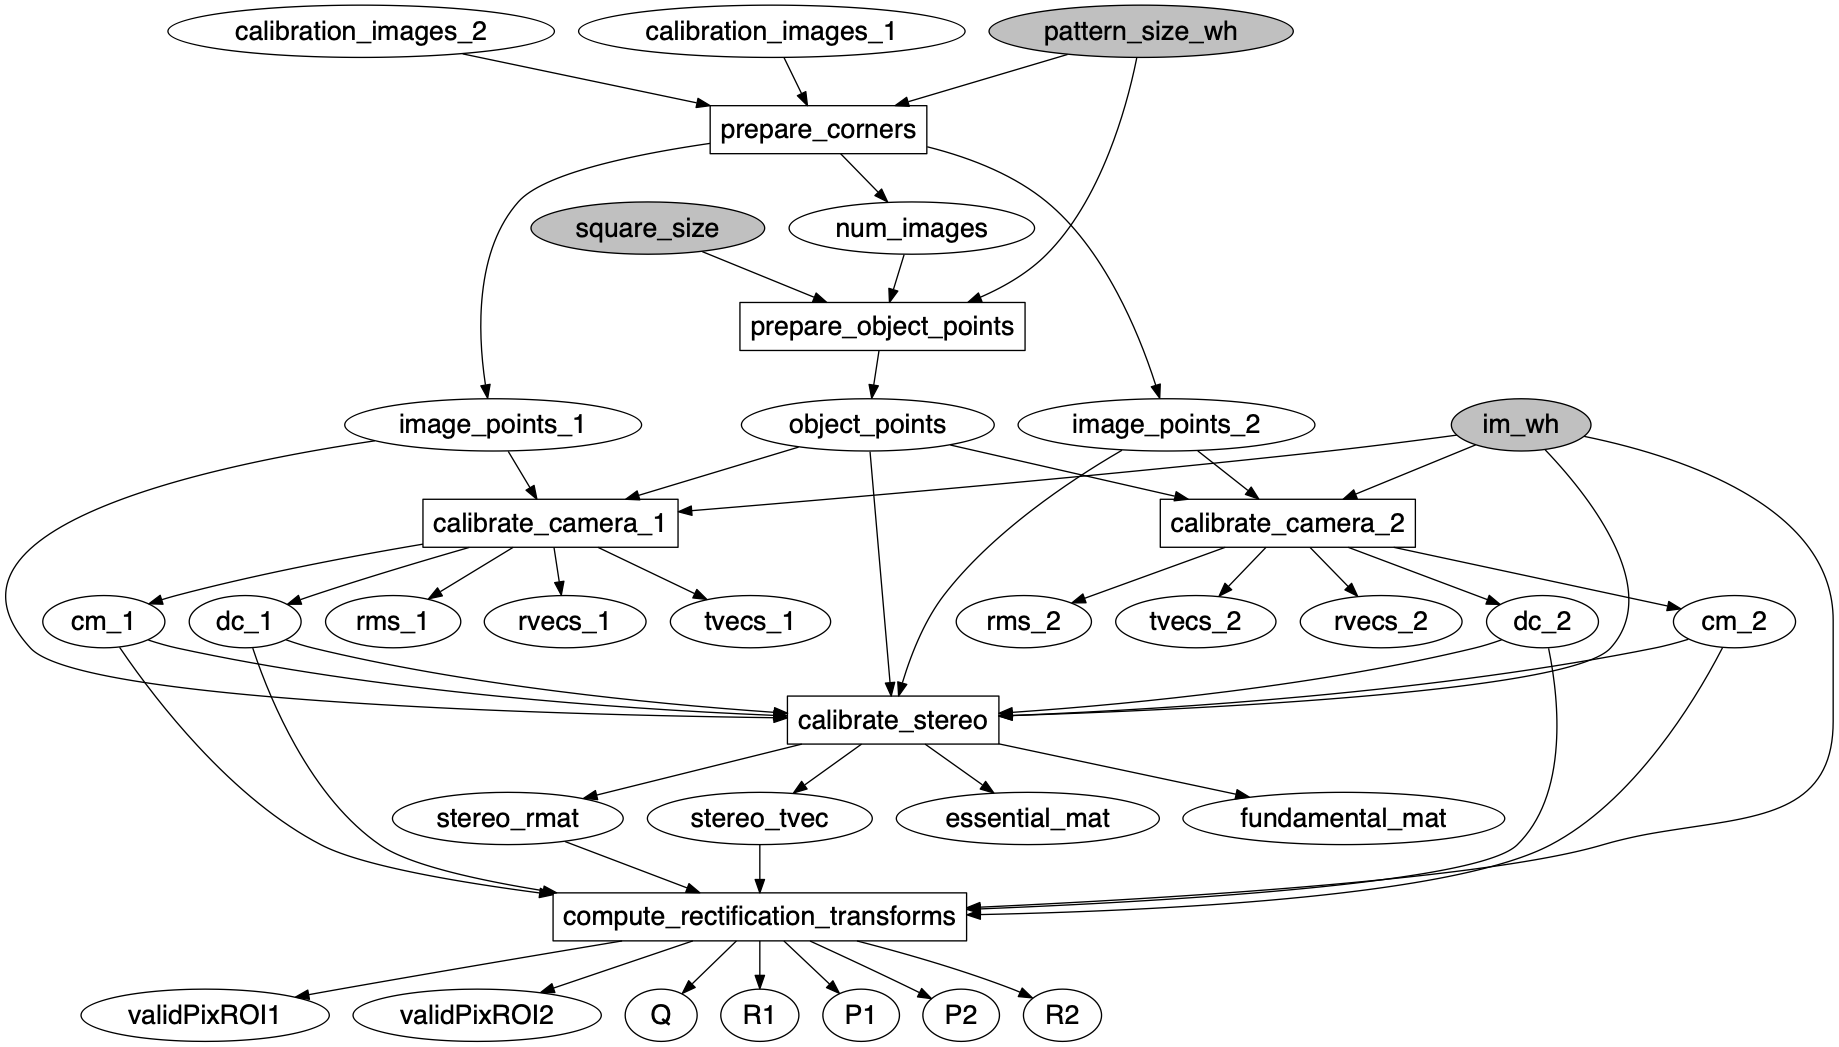

In [7]:
params = {
    'im_wh': cbcalib.get_im_wh(images1[0]),
    'pattern_size_wh': psize,
    'square_size': sq_size   
}

pipe = pipeline.Pipeline('StereoCalibSerial', cg_stereocalib, frozen_tokens=params)

nxg = pipe.runner.token_manager.to_networkx()
for node_name in nxg.nodes():
    nxg.node[node_name]['fontname'] = 'Helvetica'
    nxg.node[node_name]['fontsize'] = 20

nxpd.draw(nxg)

In [8]:
pipe.run(calibration_images_1=images1, calibration_images_2=images2)

In [9]:
print('Number of calibration images opened: ', len(pipe['calibration_images_1']))
print('Number of images with good corners', len(pipe['image_points_1']))

Number of calibration images opened:  13
Number of images with good corners 13


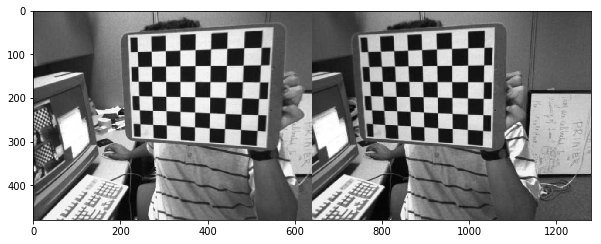

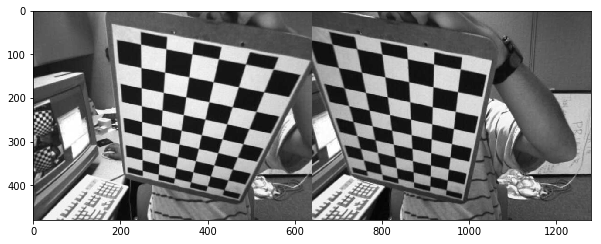

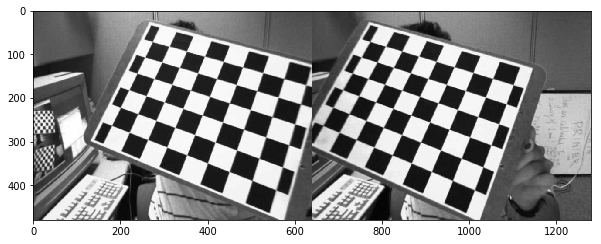

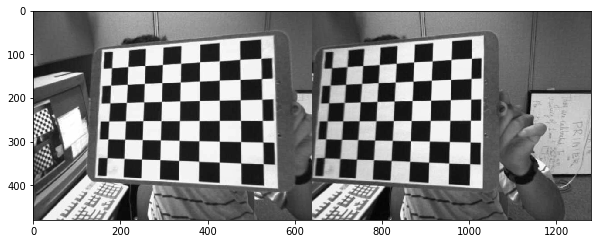

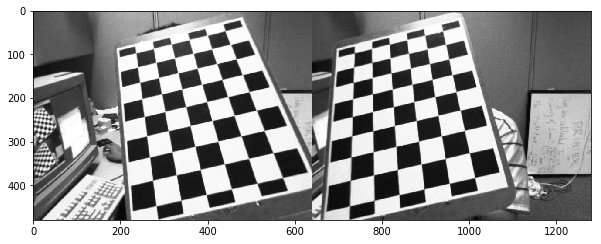

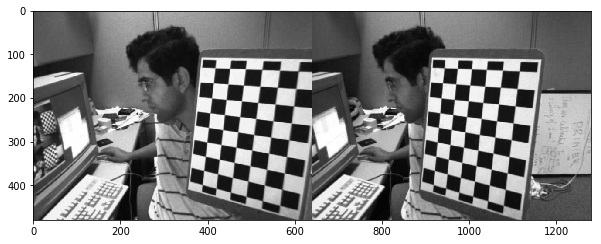

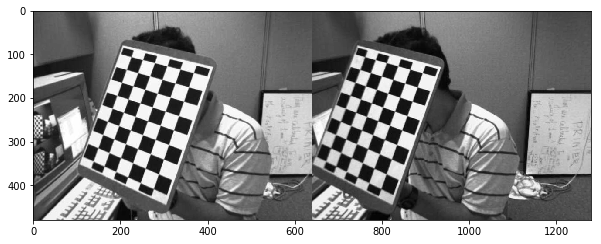

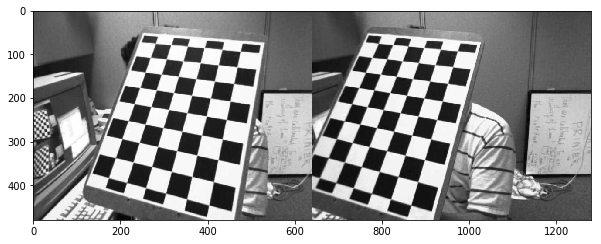

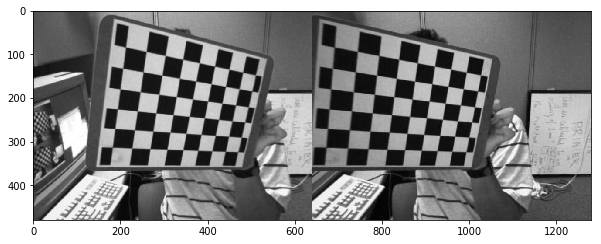

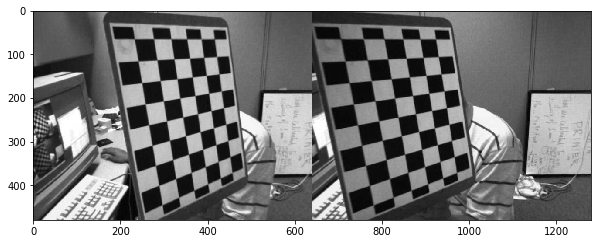

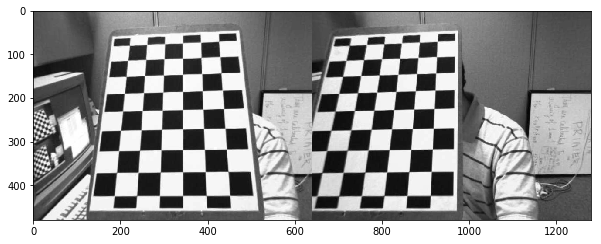

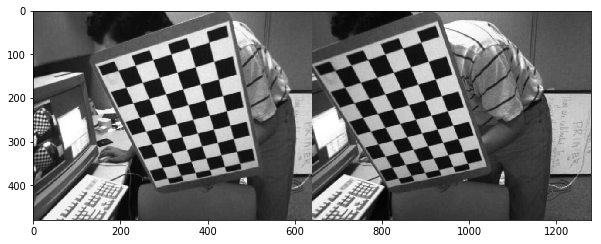

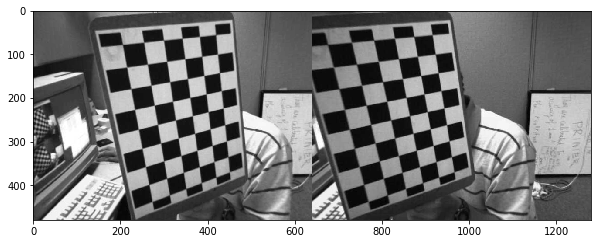

In [14]:
images1_rect, images2_rect, maps1, maps2 = cbcalib.undistort_and_rectify_images_stereo(
    images1,
    images2,
    pipe['cm_1'],
    pipe['dc_1'],
    pipe['cm_2'],
    pipe['dc_2'],
    pipe['R1'],
    pipe['R2'],
    pipe['P1'],
    pipe['P2']
)

for i in range(len(images1_rect)):
    plt.figure(figsize=(10, 20))
    plt.gray()
    plt.imshow(np.hstack((images1_rect[i], images2_rect[i])))

As you can see from the printout of `traverse_time`, the `prepare_corners` is the major bottleneck.

In [11]:
pipe.run(calibration_images_1=images1, calibration_images_2=images2)
pipe.traverse_time()

('StereoCalibSerial',
 0.9574360847473145,
 (('prepare_corners', 0.31564903259277344),
  ('prepare_object_points', 8.988380432128906e-05),
  ('calibrate_camera_1', 0.3206820487976074),
  ('calibrate_camera_2', 0.27613115310668945),
  ('calibrate_stereo', 0.04457211494445801),
  ('compute_rectification_transforms', 6.389617919921875e-05)))

In [12]:
pipe['stereo_rmat']

array([[ 0.99998578,  0.00376589,  0.00377484],
       [-0.00374027,  0.99997007, -0.00677299],
       [-0.00380023,  0.00675878,  0.99996994]])

In [13]:
pipe['stereo_tvec']

array([[-33.28061009],
       [  0.37384351],
       [  0.14698833]])

In [17]:
pipe['R1']

array([[ 9.99971744e-01, -7.49614852e-03, -5.65542051e-04],
       [ 7.49420317e-03,  9.99966250e-01, -3.36689307e-03],
       [ 5.90761694e-04,  3.36255965e-03,  9.99994172e-01]])